# VGG 19

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [12]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    x = x.numpy()
    # Util function to convert a tensor into a valid image
    x = x.reshape((IMAGE_SIZE, IMAGE_SIZE, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [13]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    # x.shape = (256, 256, n_chanels)
    x = tf.transpose(x, (2, 0, 1))
    # x.shape = (n_chanels, 256, 256)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    # features.shape = (n_chanels, 256*256)
    gram = tf.matmul(features, tf.transpose(features))
    # gram.shape = (n_chanels, n_chanels)
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, generated):
    S = gram_matrix(style)
    C = gram_matrix(generated)
    channels = 3
    size = IMAGE_SIZE * IMAGE_SIZE * channels
    return tf.reduce_mean(tf.square(S - C)) /  (size ** 2)


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, generated):
    return tf.reduce_mean(tf.square(generated - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(generated):
    img_nrows = generated.shape[1]
    img_ncols = generated.shape[2]
    horizontal_shift_diff = tf.square(
        generated[:, : img_nrows - 1, : img_ncols - 1, :] - generated[:, 1:, : img_ncols - 1, :]
    )
    vertical_shift_diff = tf.square(
        generated[:, : img_nrows - 1, : img_ncols - 1, :] - generated[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_mean(tf.pow(horizontal_shift_diff + vertical_shift_diff, 1.25))

In [14]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
vgg19_model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in vgg19_model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=vgg19_model.inputs, outputs=outputs_dict)

In [15]:
def compute_loss(combination_image, base_image, style_reference_image):
    # List of layers to use for the style loss.
    style_layer_names = {
        "block1_conv1": 1.,
        "block2_conv1": 0.75,
        "block3_conv1": 0.3,
        "block4_conv1": 0.2,
        "block5_conv1": 0.2,
    }
    # The layer to use for the content loss.
    content_layer_name = "block5_conv2"
    # Weights of the different loss components
    total_variation_weight = 1e-1
    style_weight = 1e-2
    content_weight = 2.5e-2
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    # Initialize the loss
    loss = tf.zeros(shape=())
    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name, weight in style_layer_names.items():
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = weight * style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


# Add a tf.function decorator to loss & gradient computation
# to compile it, and thus make it fast.
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_reference_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

In [16]:
def generate_image(base_image_path, style_reference_image_path, result_prefix, iterations):
    base_image = preprocess_image(base_image_path)
    style_reference_image = preprocess_image(style_reference_image_path)
    generated_image = tf.Variable(preprocess_image(base_image_path))
    optimizer = keras.optimizers.SGD(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
        )
    )
    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(
            generated_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, generated_image)])
        if i % 50 == 0:
            print("Iteration %d: loss=%.2f" % (i, loss))
            img = deprocess_image(generated_image)
            fname = result_prefix + "_at_iteration_%d.jpg" % i
            keras.preprocessing.image.save_img(fname, img)
    return deprocess_image(generated_image)

In [18]:
def batch_generation(path_content, path_style, n_images, iterations, is_random_base=True, is_random_style=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)    
    w = 3 * int(n_images ** .5)
    h = math.ceil(3 * n_images / w)
    all_content_names = os.listdir(path_content)
    all_style_names = os.listdir(path_style)
    if is_random_style:
        style_image_names = random.choices(all_style_names, k=n_images)
    else:
        style_image_names = all_style_names[:n_images]
    if is_random_base:
        content_image_names = random.choices(all_content_names, k=n_images)
    else:
        content_image_names = all_content_names[:n_images]
    for ind, (content_image_name, style_image_name) in enumerate(zip(content_image_names, style_image_names)):
        base_image_path = os.path.join(path_content, content_image_name)
        style_reference_image_path = os.path.join(path_style, style_image_name)
        result_prefix = os.path.join("D:\Land and Water Resource Engineering\Placement-I\Dashtoon",content_image_name)
        img = generate_image(base_image_path, style_reference_image_path, result_prefix, iterations)
        plt.subplot(h, w, 3*ind + 1)
        base_img = keras.preprocessing.image.load_img(
            base_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
        )
        plt.imshow(base_img)
        plt.axis("off")
        plt.subplot(h, w, 3*ind + 2)
        style_img = keras.preprocessing.image.load_img(
            style_reference_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
        )
        plt.imshow(style_img)
        plt.axis("off")
        plt.subplot(h, w, 3*ind + 3)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

Iteration 50: loss=1094.19
Iteration 100: loss=853.12
Iteration 150: loss=742.05
Iteration 200: loss=672.71
Iteration 250: loss=624.22
Iteration 300: loss=587.90
Iteration 50: loss=7850.06
Iteration 100: loss=5250.20
Iteration 150: loss=4018.75
Iteration 200: loss=3285.19
Iteration 250: loss=2791.17
Iteration 300: loss=2436.62
Iteration 50: loss=5025.53
Iteration 100: loss=3348.67
Iteration 150: loss=2768.78
Iteration 200: loss=2486.23
Iteration 250: loss=2316.35
Iteration 300: loss=2200.80


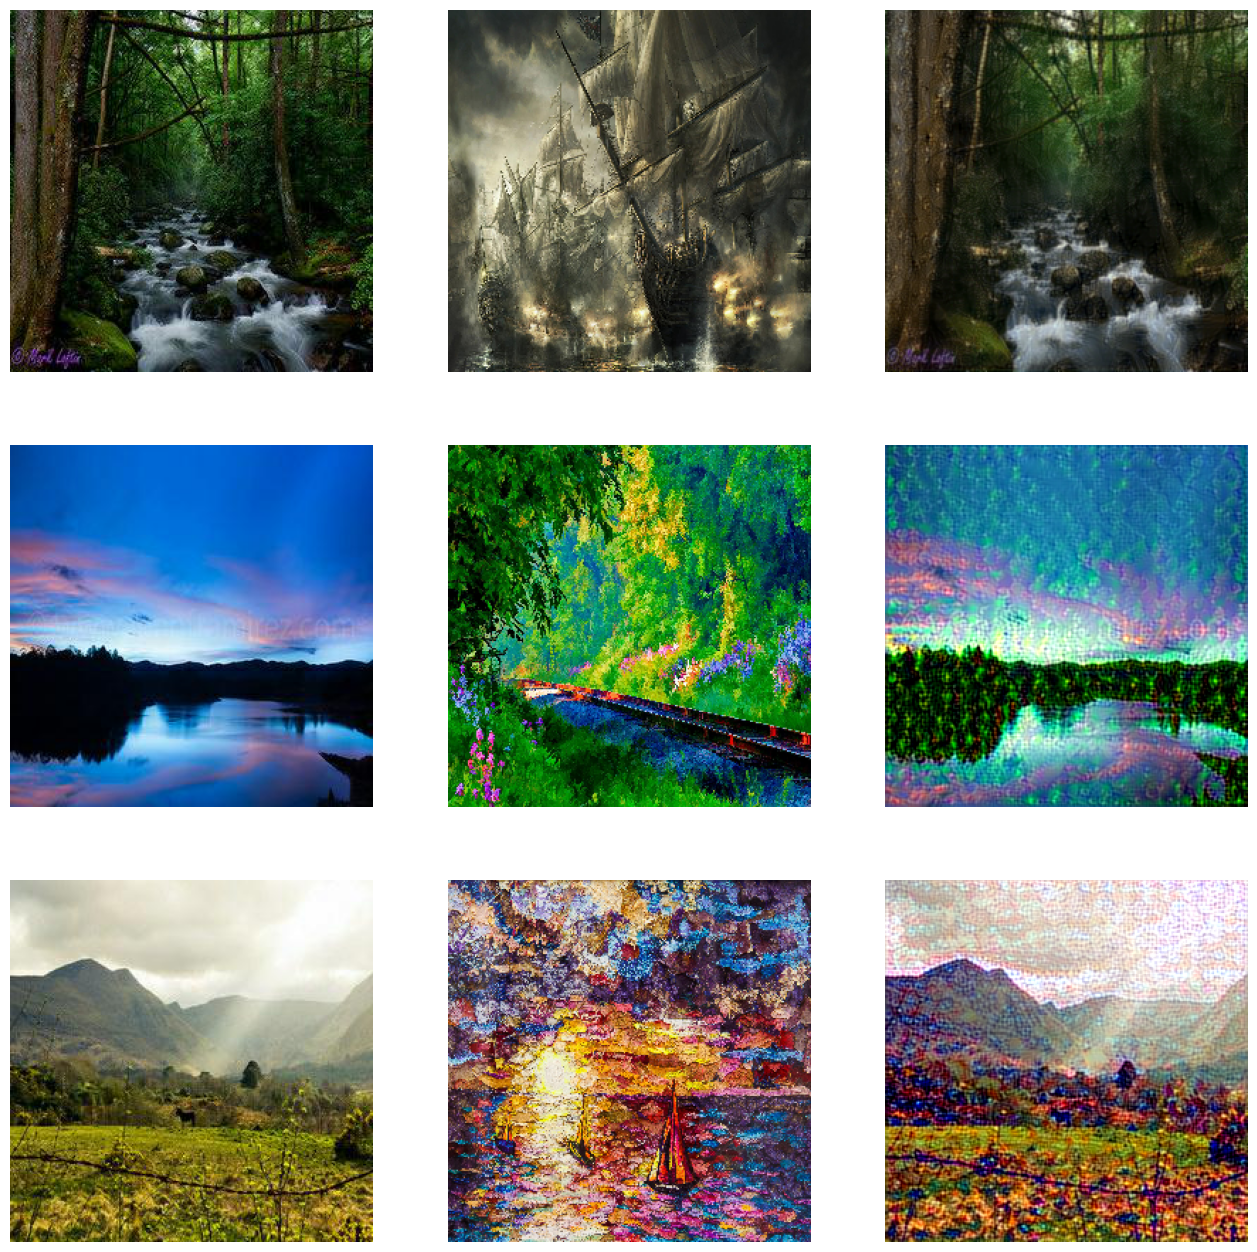

CPU times: total: 4h 29min 55s
Wall time: 19min 7s


In [19]:
%%time
random.seed(11)
batch_generation("D:\Land and Water Resource Engineering\Placement-I\Dashtoon\photo_jpg", "D:\Land and Water Resource Engineering\Placement-I\Dashtoon\Artworks", 3, 300, is_random_base=True, is_random_style=True)

Iteration 50: loss=941.36
Iteration 100: loss=790.75
Iteration 150: loss=720.22
Iteration 200: loss=675.71
Iteration 250: loss=643.29
Iteration 300: loss=617.94
Iteration 50: loss=2327.38
Iteration 100: loss=1982.09
Iteration 150: loss=1791.80
Iteration 200: loss=1662.07
Iteration 250: loss=1565.96
Iteration 300: loss=1491.16
Iteration 50: loss=1894.09
Iteration 100: loss=1766.44
Iteration 150: loss=1674.63
Iteration 200: loss=1598.37
Iteration 250: loss=1531.35
Iteration 300: loss=1470.49


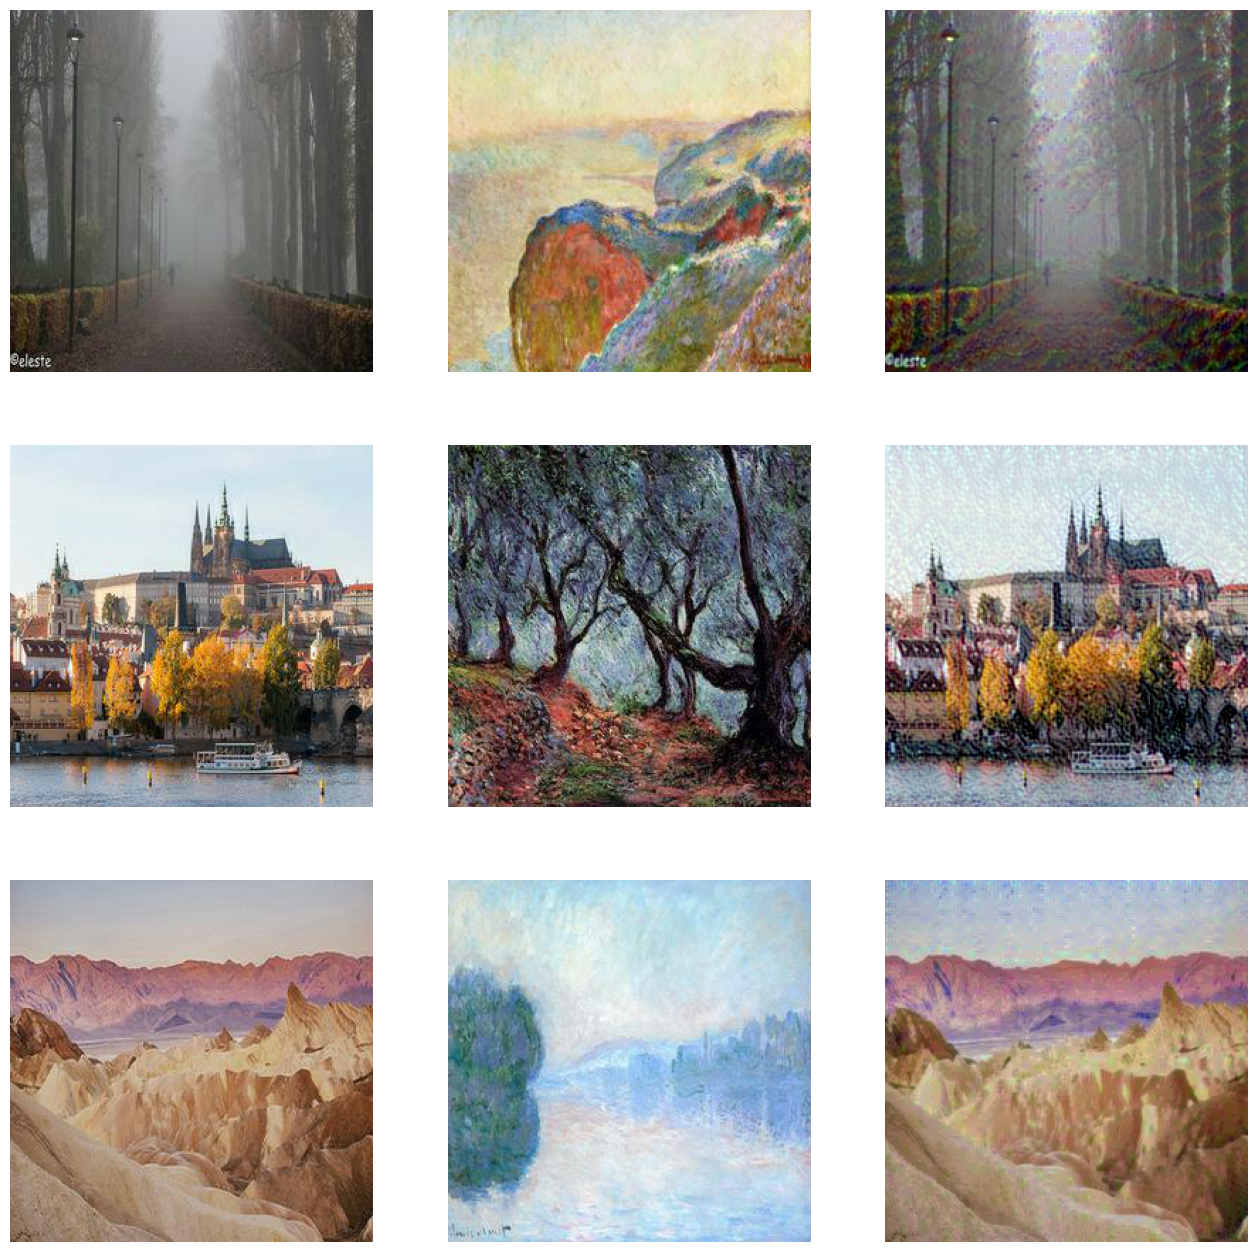

CPU times: total: 4h 25min 18s
Wall time: 18min 9s


In [20]:
%%time
random.seed(11)
batch_generation("D:\Land and Water Resource Engineering\Placement-I\Dashtoon\photo_jpg", "D:\Land and Water Resource Engineering\Placement-I\Dashtoon\monet_jpg", 3, 300, is_random_base=True, is_random_style=False)

Iteration 50: loss=3374.52
Iteration 100: loss=2771.93
Iteration 150: loss=2267.25
Iteration 200: loss=1891.88
Iteration 250: loss=1624.19
Iteration 300: loss=1435.17
Iteration 50: loss=30786.03
Iteration 100: loss=26549.48
Iteration 150: loss=21878.00
Iteration 200: loss=17581.78
Iteration 250: loss=14340.27
Iteration 300: loss=12353.33
Iteration 50: loss=36250.70
Iteration 100: loss=29891.10
Iteration 150: loss=22483.34
Iteration 200: loss=15982.36
Iteration 250: loss=11771.32
Iteration 300: loss=9634.51


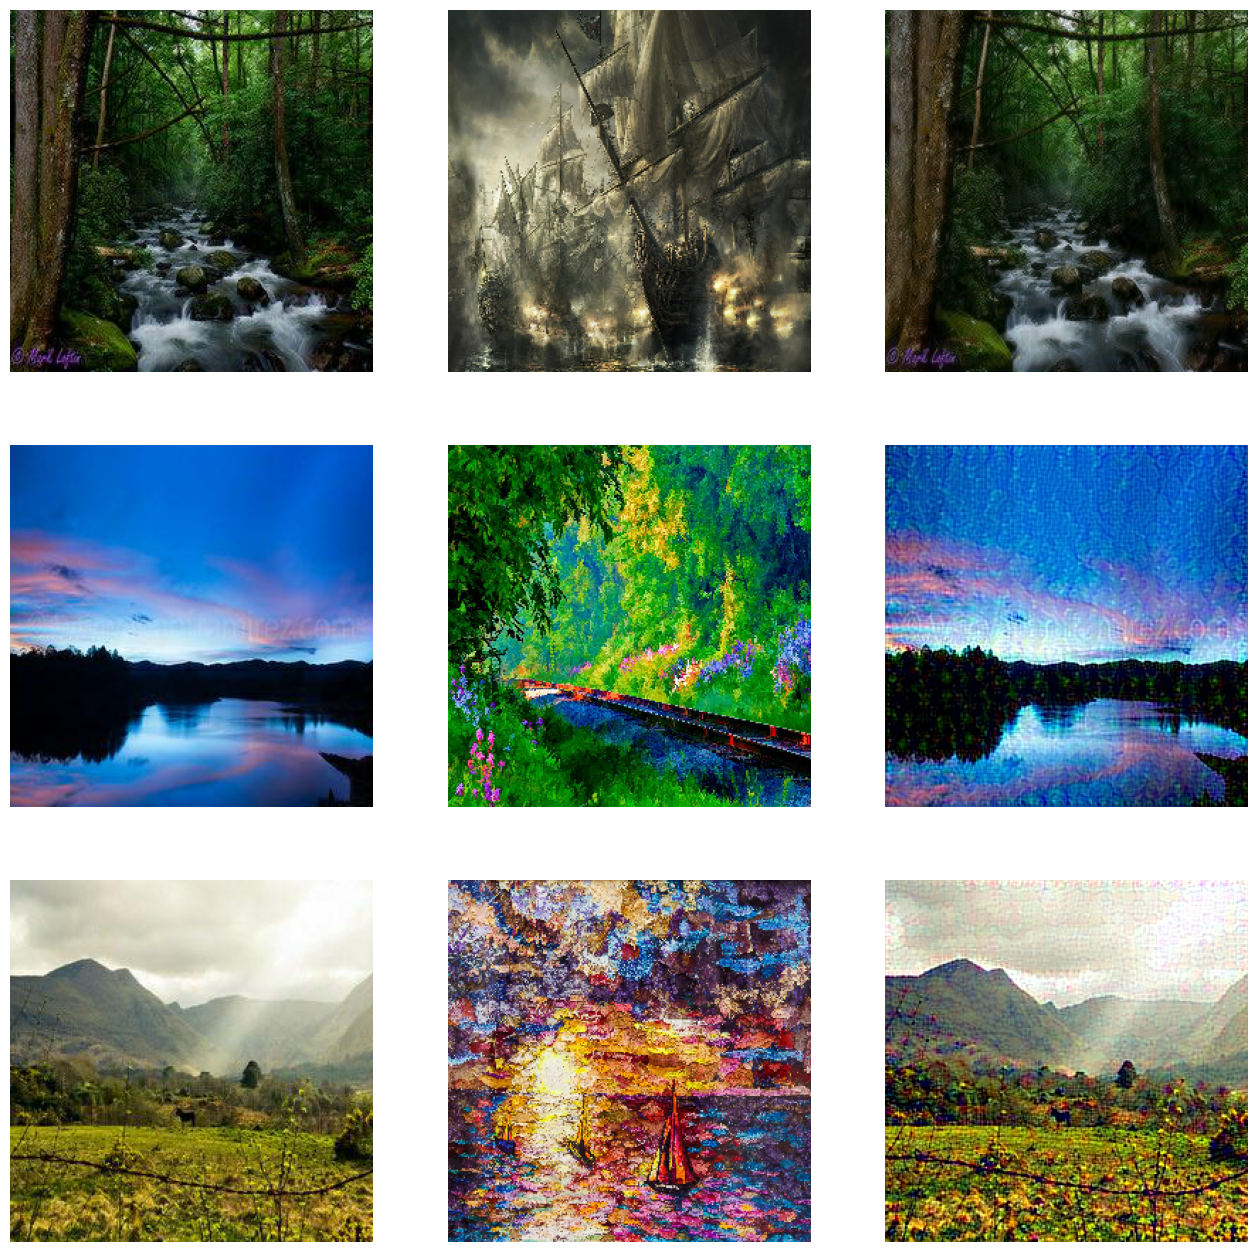

In [10]:
import os
import random
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt

# Ensure the specified directories exist
os.makedirs("D:\Land and Water Resource Engineering\Placement-I\Dashtoon", exist_ok=True)

# Function to preprocess an image
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

# Function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.numpy()
    x = x.reshape((IMAGE_SIZE, IMAGE_SIZE, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Function to generate an image using neural style transfer
def generate_image(base_image_path, style_reference_image_path, result_prefix, iterations):
    base_image = preprocess_image(base_image_path)
    style_reference_image = preprocess_image(style_reference_image_path)
    generated_image = tf.Variable(preprocess_image(base_image_path))
    
    # Use the Adam optimizer for better convergence
    optimizer = keras.optimizers.Adam(learning_rate=2.0, beta_1=0.99, epsilon=1e-1)
    
    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(
            generated_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, generated_image)])
        
        if i % 50 == 0:
            print("Iteration %d: loss=%.2f" % (i, loss))
            img = deprocess_image(generated_image)
            fname = result_prefix + "_at_iteration_%d.jpg" % i
            keras.preprocessing.image.save_img(fname, img)
    
    return deprocess_image(generated_image)

# Function to generate images in batches
def batch_generation(path_content, path_style, n_images, iterations, is_random_base=True, is_random_style=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)    
    w = 3 * int(n_images ** .5)
    h = math.ceil(3 * n_images / w)
    all_content_names = os.listdir(path_content)
    all_style_names = os.listdir(path_style)
    
    if is_random_style:
        style_image_names = random.choices(all_style_names, k=n_images)
    else:
        style_image_names = all_style_names[:n_images]
    
    if is_random_base:
        content_image_names = random.choices(all_content_names, k=n_images)
    else:
        content_image_names = all_content_names[:n_images]
    
    for ind, (content_image_name, style_image_name) in enumerate(zip(content_image_names, style_image_names)):
        base_image_path = os.path.join(path_content, content_image_name)
        style_reference_image_path = os.path.join(path_style, style_image_name)
        result_prefix = os.path.join("D:\Land and Water Resource Engineering\Placement-I\Dashtoon", content_image_name.split('.')[0])
        img = generate_image(base_image_path, style_reference_image_path, result_prefix, iterations)
        
        plt.subplot(h, w, 3*ind + 1)
        base_img = keras.preprocessing.image.load_img(
            base_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
        )
        plt.imshow(base_img)
        plt.axis("off")
        
        plt.subplot(h, w, 3*ind + 2)
        style_img = keras.preprocessing.image.load_img(
            style_reference_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
        )
        plt.imshow(style_img)
        plt.axis("off")
        
        plt.subplot(h, w, 3*ind + 3)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

# %%time
random.seed(11)
# Set IMAGE_SIZE to the appropriate size for your model
IMAGE_SIZE = 256
# Run batch generation
batch_generation(
    "D:/Land and Water Resource Engineering/Placement-I/Dashtoon/photo_jpg",
    "D:/Land and Water Resource Engineering/Placement-I/Dashtoon/Artworks",
    3,
    300,
    is_random_base=True,
    is_random_style=True
)
